# ECE 590, Fall 2019 
## Problem Set 6


## Full name: Lidia Azucena Morales Vasquez

## Problem 1 Bayesian Network
#### True or False

$(H \perp L)|P$ is false, because $L$ also has depends on $G$ that depends in $H$.

$(H \perp L)|P,G$ is true, because $L$ depends on $H$ through $P, G$, if they are given then they are independent

$(P \perp D)|G$ is true, because $P$ depends on $D$ through $G$, if $G$ is given then they are independent

$(H \perp D)|L$ is false, $H$ and $D$ are dependent through $G$.

#### Joint distribution

$P(H,D,P,G,L) = P(H) P(D) P(G|D,H) P(P|H,G) P(L|G,P)$

#### Probability of obtaining letter of recommendation

$
\begin{aligned}
P(L = 1) &= P(L=1|P =A, G = A) P(P=A,G=A) + P(L=1|P =A, G = B) P(P=A,G=B) + P(L=1|P =B, G = A) P(P=B,G =A) + P(L=1|P =B, G = B) P(P=B,G=B) \\
& = .8(.4) + .3(.6)+ .1(.3)+.2(.1) \\
& = .55
\end{aligned}
$

## Problem 2 (Image Denoising using Singular Value Decomposition)

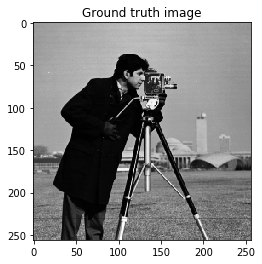

'\nReconstruct the image based on the SVD of the noisy image, then report the PSNR with respect\nto the ground truth image \n'

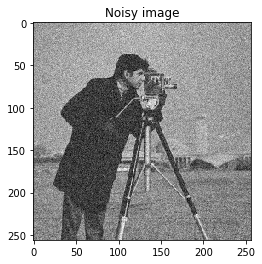

In [5]:
import numpy as np
import imageio
import matplotlib.pyplot as plt

# reading the ground truth image 
im = imageio.imread('cameraman.png')

# normalize the image 
im = (im - np.min(im))/(np.max(im) - np.min(im))

# visualize the image 
plt.imshow(im, cmap="gray")
plt.title("Ground truth image")
plt.show()

# add some noise to the image 
n = 0.1 * np.random.randn(256,256)

# noisy image
im_noisy = im + n

# visualize the image 
plt.imshow(im_noisy, cmap="gray")
plt.title("Noisy image")

"""
Reconstruct the image based on the SVD of the noisy image, then report the PSNR with respect
to the ground truth image 
"""


In [42]:
import scipy.linalg as la
import numpy as np

def SVD(image, k):
    """Returns the singular value decomposition of an image using K principal components"""
    U, S, V = la.svd(image)
    return U[:,:k] @ np.diag(S[:k])@ V[:k, :]

def MSE(imagA, imagB):
    """Returns mean square error between two images"""
    err = np.sum((imagA.astype("float") - imagB.astype("float")) ** 2) / float(imagA.shape[0] * imagA.shape[1])
    return err
    
def MAX(image):
    """ Returns the maximum possible pixel value of the image"""
    return np.max(image)

psnr = list()
for k in range(1,101):
    im_svd = SVD(im_noisy,k)
    mse = MSE(im_svd, im)
    psnr.append(10*np.log10(1/mse))

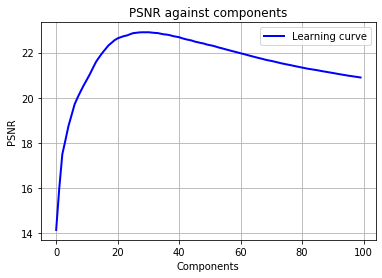

In [43]:
import matplotlib.pyplot as plt 
plt.figure()
plt.title("PSNR against components")
plt.plot(list(range(len(psnr))), psnr, color='blue', linewidth=2, label='Learning curve')
plt.legend()
plt.xlabel('Components')
plt.ylabel('PSNR')
plt.grid()
plt.show()

Text(0.5, 1.0, 'Denoise Image using 30 k first eigenvectos')

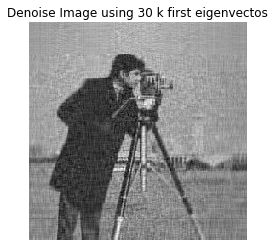

In [54]:
k = np.where(psnr == max(psnr))[0][0]
denoise_img = SVD(im_noisy,k)
plt.imshow(denoise_img, cmap="gray")
plt.gca().set_axis_off()
plt.title("Denoise Image using {} k first eigenvectos".format(k))

## Problem 3 Feature Extraction using Autoencoder

In [8]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import os
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [9]:
batch_size = 128
Num_epoch = 20
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])
Datset = torchvision.datasets.MNIST(root='./mnist', train=True, download=True, transform=transform)
DataLoader = torch.utils.data.DataLoader(Datset, batch_size=batch_size, shuffle=True, num_workers=0)
Datset_test = torchvision.datasets.MNIST(root='./mnist', train=False, download=True, transform=transform)
DataLoader_test = torch.utils.data.DataLoader(Datset_test, batch_size=100, shuffle=True, num_workers=0)

def Array_to_Image(x):
    x = 0.5*x + 0.5
    x = x.view(x.size(0), 1, 28, 28)
    return x
if not os.path.exists('./Image_gen'):
    os.mkdir('./Image_gen')

In [10]:
class AutoEncoder(nn.Module):
    def __init__(self):
        
        super(AutoEncoder, self).__init__()
        self.Encoder = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, 12),
            nn.ReLU(True),
            nn.Linear(12, 3)
        )
        self.Decoder = nn.Sequential(
            nn.Linear(3, 12, 3),
            nn.ReLU(True),
            nn.Linear(12, 64, 3),
            nn.ReLU(True),
            nn.Linear(64, 128, 3),
            nn.ReLU(True),
            nn.Linear(128, 784, 3),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.Encoder(x)
        x = self.Decoder(x)
        return x

In [11]:
model = AutoEncoder()
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr= 1e-3, weight_decay= 1e-4)
criterion  = nn.MSELoss()

In [12]:
min_loss = 10e+10
for epoch in range(Num_epoch):
    running_loss = 0 
    for batch_ind, (image,_) in enumerate(DataLoader):
        image = image.to(device)
        img = image.view(image.size(0),-1)
        optimizer.zero_grad()
        output = model(img)
        loss = criterion(img, output)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print('Epoch {}: Loss: {:.4f}'.format(epoch, running_loss/(batch_ind+1)))
    Img = Array_to_Image(output)
    save_image(Img, './Image_gen/Im_{}.png'.format(epoch))
    if (running_loss/(batch_ind+1)) < min_loss:
        torch.save(model, 'ckpt_autoencoder.pth')
        min_loss = running_loss/(batch_ind+1)

Epoch 0: Loss: 0.2532


/home/azucena/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type AutoEncoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch 1: Loss: 0.1936
Epoch 2: Loss: 0.1755
Epoch 3: Loss: 0.1671
Epoch 4: Loss: 0.1612
Epoch 5: Loss: 0.1563
Epoch 6: Loss: 0.1526
Epoch 7: Loss: 0.1497
Epoch 8: Loss: 0.1474
Epoch 9: Loss: 0.1458
Epoch 10: Loss: 0.1445
Epoch 11: Loss: 0.1432
Epoch 12: Loss: 0.1423
Epoch 13: Loss: 0.1415
Epoch 14: Loss: 0.1407
Epoch 15: Loss: 0.1399
Epoch 16: Loss: 0.1394
Epoch 17: Loss: 0.1389
Epoch 18: Loss: 0.1383
Epoch 19: Loss: 0.1380


### Contractive AutoEncoder

In [ ]:
class CAutoEncoder(nn.Module):
    def __init__(self):
        super(CAutoEncoder, self).__init__()
        self.Encoder = nn.Sequential(
            nn.Linear(784, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, 12),
            nn.ReLU(True),
            nn.Linear(12, 3)
        )
        self.Decoder = nn.Sequential(
            nn.Linear(3, 12, 3),
            nn.ReLU(True),
            nn.Linear(12, 64, 3),
            nn.ReLU(True),
            nn.Linear(64, 128, 3),
            nn.ReLU(True),
            nn.Linear(128, 784, 3),
            nn.Tanh()
        )

    def forward(self, x):
        encoder = self.Encoder(x)
        decoder = self.Decoder(encoder)
        return decoder, encoder

In [ ]:
def reg_loss(criterion, lam, img, output, encoder):
    loss = criterion(img, output)
    encoder.backward(torch.zeros(encoder.size()),retain_graph = True)
    reg_term = torch.norm(img.grad, p = "fro")
    img.grad.data.zero_()
    reg_loss = lam * reg_term
    return loss + reg_loss

In [82]:
model = CAutoEncoder()
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr= 1e-3, weight_decay= 1e-4)
criterion  = nn.MSELoss()
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=step_val, gamma=gamma_val)
## COntractive
min_loss = 10e+10
lam = .0001
for epoch in range(Num_epoch):
    running_loss = 0 
    for batch_ind, (image,_) in enumerate(DataLoader):
        image = image.to(device)
        img = image.view(image.size(0),-1)
        img.requires_grad_(True)
        optimizer.zero_grad()
        output,encoder = model(img)
        #print(img.grad)
        loss = reg_loss(criterion, lam, img, output, encoder)
        img.requires_grad_(False)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print('Epoch {}: Loss: {:.4f}'.format(epoch, running_loss/(batch_ind+1)))
    Img = Array_to_Image(output)
    save_image(Img, './Image_gen/Im_{}.png'.format(epoch))
    if (running_loss/(batch_ind+1)) < min_loss:
        torch.save(model, 'ckpt_cautoencoder.pth')
        min_loss = running_loss/(batch_ind+1)

Epoch 0: Loss: 0.2548
Epoch 1: Loss: 0.1887
Epoch 2: Loss: 0.1744
Epoch 3: Loss: 0.1640
Epoch 4: Loss: 0.1584
Epoch 5: Loss: 0.1547
Epoch 6: Loss: 0.1523
Epoch 7: Loss: 0.1504
Epoch 8: Loss: 0.1488
Epoch 9: Loss: 0.1475
Epoch 10: Loss: 0.1465
Epoch 11: Loss: 0.1456
Epoch 12: Loss: 0.1448
Epoch 13: Loss: 0.1440
Epoch 14: Loss: 0.1433
Epoch 15: Loss: 0.1426
Epoch 16: Loss: 0.1421
Epoch 17: Loss: 0.1414
Epoch 18: Loss: 0.1408
Epoch 19: Loss: 0.1404


### PCA

In [86]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

## PCA
pca = PCA(n_components=3)
pca.fit(train_img)

PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

### Multiple Logistic Regression Accuracy 

In [87]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics


In [88]:
batch_train = len(Datset)
batch_test = len(Datset_test)

DataLoaderTrain = torch.utils.data.DataLoader(Datset, batch_size = batch_train, shuffle=True, num_workers=0)
DataLoaderTest = torch.utils.data.DataLoader(Datset_test, batch_size= batch_test, shuffle=True, num_workers=0)

## Train and test images
img,lbl = next(iter(DataLoaderTrain))
train_img = img.view(img.size(0),-1)
train_lbl = lbl.view(lbl.size(0),-1)

img,lbl = next(iter(DataLoaderTest))
test_img = img.view(img.size(0),-1)
test_lbl = lbl.view(lbl.size(0),-1)

In [90]:
## Logistic Regression Training (Autoencoder)
model_autoencode =  torch.load('ckpt_autoencoder.pth')
with torch.no_grad():
    model_autoencode.eval()
    train_img = train_img.to(device)
    train_output_ae = model_autoencode.Encoder(train_img)

LogRegAE = LogisticRegression(multi_class="multinomial",max_iter = 1000,solver = 'lbfgs')
LogRegAE.fit(train_output_ae, train_lbl.reshape(-1))

# Logistic Regression Training (Contractive Autoencoder)
model_cautoencode =  torch.load('ckpt_cautoencoder.pth')
with torch.no_grad():
    model_cautoencode.eval()
    train_img = train_img.to(device)
    train_output_cae = model_cautoencode.Encoder(train_img)

LogRegCAE = LogisticRegression(multi_class="multinomial",max_iter = 1000,solver = 'lbfgs')
LogRegCAE.fit(train_output_cae, train_lbl.reshape(-1))

## Logistic Regression Training (PCA)
train_img_pca = pca.transform(train_img)
LogRegPCA = LogisticRegression(multi_class="multinomial",max_iter = 1000,solver = 'lbfgs')
LogRegPCA.fit(train_img_pca, train_lbl.reshape(-1))


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [92]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

## Logistic Regression Prediction (Autoencoder)
with torch.no_grad():
    model_autoencode.eval()
    test_img = test_img.to(device)
    test_output_ae = model_autoencode.Encoder(test_img)
    
y_pred_ae = LogRegAE.predict(test_output_ae)
accuracy_ae = metrics.accuracy_score(test_lbl, y_pred_ae)
print('Accuracy of feature extraction using Autoencoder: {:.2f}'.format(accuracy_ae))

## Logistic Regression Prediction (Contractive Autoencoder)
with torch.no_grad():
    model_cautoencode.eval()
    test_img = test_img.to(device)
    test_output_cae = model_cautoencode.Encoder(test_img)
    
y_pred_cae = LogRegCAE.predict(test_output_cae)
accuracy_cae = metrics.accuracy_score(test_lbl, y_pred_cae)
print('Accuracy of feature extraction using Contractive Autoencoder: {:.2f}'.format(accuracy_cae))


## Logistic Regression Prediction (PCA)
test_img_pca = pca.transform(test_img)
y_pred_pca = LogRegPCA.predict(test_img_pca)
accuracy_pca = metrics.accuracy_score(test_lbl, y_pred_pca)
print('Accuracy of feature extraction using PCA: {:.2f}'.format(accuracy_pca))


Accuracy of feature extraction using Autoencoder: 0.74
Accuracy of feature extraction using Contractive Autoencoder: 0.75
Accuracy of feature extraction using PCA: 0.48
